As with all notebooks, we start with importing several Python libraries and verifying our file location:

In [1]:
#Import related modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import requests

os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Loans-In-Colorado'

In [2]:
# Read csv file using chunks and add CO-specific rows into a new dataframe\n",
file = 'SBAnational.csv'

sba_reader = pd.read_csv(file, chunksize=5000)

co_data = pd.DataFrame()

for sba_chunk in sba_reader:
    sba_add = sba_chunk[sba_chunk['State'] == 'CO']
    co_data = co_data.append(sba_add)

sba_reader.close()

nRow, nCol = co_data.shape
print(f'There are {nRow} rows and {nCol} columns')
   

There are 20605 rows and 27 columns


In [3]:
print(co_data['MIS_Status'].value_counts())

P I F     16927
CHGOFF     3671
Name: MIS_Status, dtype: int64


## Reducing the timespan of the dataset ##
Overall this data set is not balanced, with way more "Paid In Full" loans than not, but that of course is reality. A 4.5:1 ratio should be acceptable for many machine learning techniques. 
Next, we look at the number of loans per year, to explore how well spread out the loans are in the full time span of the data set, which is roughly 5.5 decades:

In [4]:
loan_years = pd.DataFrame(co_data['ApprovalFY'].value_counts())
loan_years['Year'] = loan_years.index
loan_years['Year'] = pd.to_numeric(loan_years['Year'])
loan_years = loan_years.sort_values('Year', ascending=False)
loan_years.head()

,ApprovalFY,Year
2014,4,2014
2013,64,2013
2012,134,2012
2011,307,2011
2010,420,2010


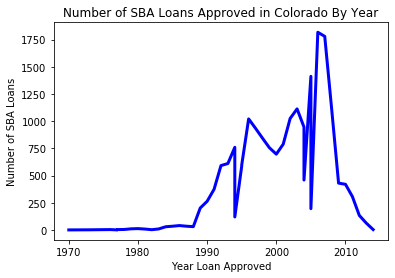

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loan_years['Year'], loan_years['ApprovalFY'], color='blue', linewidth=3)
plt.xlabel('Year Loan Approved')
plt.ylabel('Number of SBA Loans')
plt.title('Number of SBA Loans Approved in Colorado By Year')
plt.show()

Fortunately the data seems to be concentrated within a roughly 20 year time frame, from 1990 to 2010. With this observation, loans from prior to 1990 are dropped from the dataset:

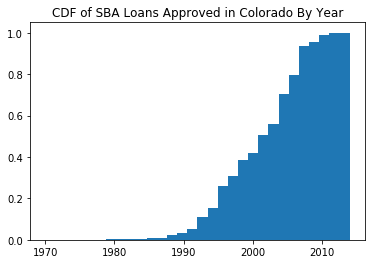

In [6]:
co_data['ApprovalFY'] = pd.to_numeric(co_data['ApprovalFY'])
plt.hist(co_data['ApprovalFY'], bins=30, cumulative=True, density=True)
plt.title('CDF of SBA Loans Approved in Colorado By Year')
plt.show()

This CDF is good news, and we can safely eliminate all years prior to 1990 from the dataset. Two decades still covers a lot of history, though: 9/11, the dotcom crash of 2000, the 2008 recession, among other things.

In [7]:
# Based on this, we can eliminate all loan data prior to 1990:

co_data = co_data[co_data.ApprovalFY >= 1990]

## How has loan repayment varied over time? ##
One question that arises is if the good/bad ratio is relatively constant over time, or if there are significant changes in pass fail rate as a function of time. For example, as can be seen below, a significant increase in loan defaults occurs for loans originated in the ~2007 time frame:

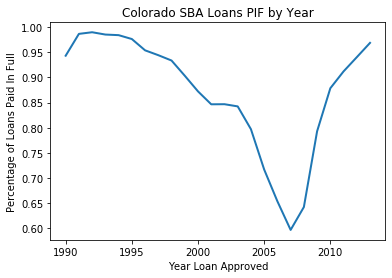

In [8]:
approved = pd.DataFrame()

for yr in range(1975,2014):
    data = co_data[co_data['ApprovalFY'] == yr]
    good = data['MIS_Status'].value_counts('P I F')
#    approved[yr] = good[0]
    approved = approved.append(good)
    
    
approved.index = range(1975,2014)
#approved.tail(10)

plt.plot(approved['P I F'], linewidth = 2.0)
plt.xlabel('Year Loan Approved')
plt.ylabel('Percentage of Loans Paid In Full')
plt.title('Colorado SBA Loans PIF by Year')
plt.show()

## Folding in county identification ##
Next step is to fold in the information for counties, since most of the GoCode Colorado data is provided by county, and county is a nice, fairly small scale refinement of the dataset. There are 63 counties in Colorado. These are pulled from a us cities CSV file. This city list does not include every single city within Colorado, but the vast majority. Hence there may a slight reduction in dataset size after inner joining this dataset to the loan dataset. Lastly, with the 'County_FIPS' column, we now have both numerical and string indices for the 63 counties, either can be used for merging future datasets. (In particular, county FIPS data is used to index county chloropleths, as will be seen later.)

In [9]:
# Preparation of county listing by city name or county fips code
# fips codes are used in a large number of GoCode Colorado files so may be a useful column to add. 

county_file = 'uscities.csv'

county = pd.read_csv(county_file, usecols= ['city','state_id','county_fips','county_name'])
county = county[county['state_id']== 'CO'].reset_index(drop=True)
county.columns = county.columns.str.title()
county.head()


,City,State_Id,County_Fips,County_Name
0,Sanford,CO,8021,Conejos
1,Aurora,CO,8001,Adams
2,Avondale,CO,8101,Pueblo
3,Alpine,CO,8105,Rio Grande
4,Pitkin,CO,8051,Gunnison


In [10]:
# Change the 'City' column to the title string format to match the county dataframe.

co_data['City'] = co_data['City'].str.title()
co_data.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
899050,9993603007,"PRECISION GAGE, INC. & CHARLES",Thornton,CO,80241,WELLS FARGO BANK NATL ASSOC,CO,0,27-Feb-97,1997,...,0,N,NaN,30-Apr-97,"$150,000.00",$0.00,P I F,$0.00,"$150,000.00","$112,500.00"
899079,9994053010,THE HIDEOUT,Parachute,CO,81635,"BUSINESS LOAN CENTER, LLC",SC,722410,27-Feb-97,1997,...,0,N,NaN,30-Apr-97,"$200,000.00",$0.00,P I F,$0.00,"$200,000.00","$150,000.00"
899118,9994833008,WEST END RENTAL,Kremmling,CO,80459,PEOPLES NATIONAL BANK,CO,0,27-Feb-97,1997,...,N,Y,NaN,31-Jul-97,"$63,000.00",$0.00,P I F,$0.00,"$63,000.00","$50,400.00"
899119,9994843000,"FRONT RANGE DRYWALL,INC.",Denver,CO,80216,COBIZ BANK,CO,235420,27-Feb-97,1997,...,N,Y,NaN,31-May-97,"$100,000.00",$0.00,P I F,$0.00,"$100,000.00","$80,000.00"
899122,9994893004,"TRIOS ENTERPRISES,INC.",Fort Collins,CO,80526,FIRST NATIONAL BANK OF OMAHA,NE,0,27-Feb-97,1997,...,N,Y,NaN,31-Mar-98,"$93,600.00",$0.00,P I F,$0.00,"$93,600.00","$74,880.00"


Inner join merge reduces the dataset from 20168 to 19372 rows, or about 4% reduction, which is acceptable. The merged dataframe is now ready to accept additional data based on county and year.

In [11]:
df = pd.merge(co_data, county, how = 'inner', on = 'City')
df.shape

(19372, 30)

In [12]:
# This creates a list of County FIPS values that matches the format in the geojson file for the choropleths:

df['County_Fips'] = df.County_Fips.astype(str)
df['County_Fips'] = ["0" + i for i in df['County_Fips'] ]


In [13]:
df.head().T

,0,1,2,3,4
LoanNr_ChkDgt,1000786003,1018664008,1035774008,1089555003,1135084010
Name,MICHAEL GADEKEN DDS PC,"MINE TECHNOLOGIES,INC.","CRAIG M. DROSKIN, D.D.S.",Johnny R. Webb II DBA Webb's A,THE DONUT SHOP PLUS
City,Grand Junction,Grand Junction,Grand Junction,Grand Junction,Grand Junction
State,CO,CO,CO,CO,CO
Zip,81506,81506,81501,81501,81504
Bank,WELLS FARGO BANK NATL ASSOC,ANB BANK,WELLS FARGO BANK NATL ASSOC,CAPITAL ONE NATL ASSOC,ANB BANK
BankState,SD,CO,SD,VA,CO
NAICS,621210,333131,621210,811111,0
ApprovalDate,7-Feb-06,7-Mar-97,14-Mar-97,25-Oct-04,16-Apr-97
ApprovalFY,2006,1997,1997,2005,1997


We can see below that the dataset is fairly heavy on a handful of counties. This makes sense, as the counties with many loans (e.g. Denver, Arapahoe, Boulder) are much higher in population. 

In [14]:
county_counts = df['County_Name'].value_counts()

county_counts.columns = ['NumLoans']
county_counts.head(20)

Denver        3647
Arapahoe      2046
El Paso       1977
Adams         1929
Jefferson     1556
Boulder       1380
Larimer       1078
Douglas        805
Weld           506
Mesa           445
Pueblo         434
La Plata       348
Broomfield     310
Eagle          293
Summit         282
Garfield       249
Montrose       156
Montezuma      149
Delta          137
Gunnison       133
Name: County_Name, dtype: int64

## Do different counties have different repayment rates? ##
Next, I want to explore the county by county variation in loan performance, using a dataframe called county_rates. A histogram of the overall percentage of repaid loans by county shows some spread in values, suggesting that how likely a loan is to be paid off may be partially a function of location in Colorado:

In [15]:
goodrate = pd.Series()

for i in range(0,63):
    c = county_counts.index[i]
    goodrate[c] = df[df['County_Name'] == c]['MIS_Status'].value_counts('P I F')[0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


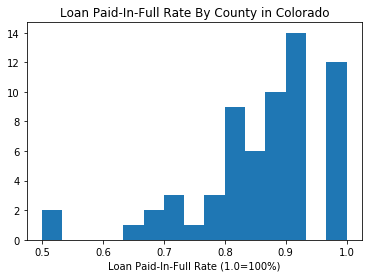

In [16]:
plt.hist(goodrate, bins=15)
plt.title('Loan Paid-In-Full Rate By County in Colorado')
plt.xlabel('Loan Paid-In-Full Rate (1.0=100%)')
plt.show()

In [17]:
goodrate['County'] = goodrate.index
county_counts['County'] = county_counts.index

In [18]:
county_rates = pd.concat([county_counts, goodrate], axis=1)

county_rates.columns = ['TotalLoansInCounty','PIF_RateByCounty']
county_rates['County_Name'] = county_rates.index

In [19]:
county_rates.head()

,TotalLoansInCounty,PIF_RateByCounty,County_Name
Denver,3647,0.839232,Denver
Arapahoe,2046,0.797654,Arapahoe
El Paso,1977,0.819838,El Paso
Adams,1929,0.752722,Adams
Jefferson,1556,0.821979,Jefferson


In [20]:
# Add the loan repayment rate and number of loans per county data to the dataframe df:

df = pd.merge(df, county_rates, how = 'left', on = 'County_Name')

In [21]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,State_Id,County_Fips,County_Name,TotalLoansInCounty,PIF_RateByCounty
0,1000786003,MICHAEL GADEKEN DDS PC,Grand Junction,CO,81506,WELLS FARGO BANK NATL ASSOC,SD,621210,7-Feb-06,2006,...,$0.00,P I F,$0.00,"$1,535,000.00","$1,151,250.00",CO,08077,Mesa,445,0.876404
1,1018664008,"MINE TECHNOLOGIES,INC.",Grand Junction,CO,81506,ANB BANK,CO,333131,7-Mar-97,1997,...,$0.00,P I F,$0.00,"$90,000.00","$72,000.00",CO,08077,Mesa,445,0.876404
2,1035774008,"CRAIG M. DROSKIN, D.D.S.",Grand Junction,CO,81501,WELLS FARGO BANK NATL ASSOC,SD,621210,14-Mar-97,1997,...,$0.00,P I F,$0.00,"$59,000.00","$47,200.00",CO,08077,Mesa,445,0.876404
3,1089555003,Johnny R. Webb II DBA Webb's A,Grand Junction,CO,81501,CAPITAL ONE NATL ASSOC,VA,811111,25-Oct-04,2005,...,$0.00,CHGOFF,"$28,061.00","$50,000.00","$25,000.00",CO,08077,Mesa,445,0.876404
4,1135084010,THE DONUT SHOP PLUS,Grand Junction,CO,81504,ANB BANK,CO,0,16-Apr-97,1997,...,$0.00,P I F,$0.00,"$21,200.00","$16,960.00",CO,08077,Mesa,445,0.876404


## Adding Data: Personal Income (and Population) from GoCode Colorado##
Now turning to the Personal income dataset from GoCode Colorado, to fold into the County dataset:

In [22]:
# Personal income dataset from GoCode Colorado

file1 = 'Personal_income_in_Colorado.csv'

income = pd.read_csv(file1, usecols=['areaname', 'periodyear', 'incdesc', 'income','population' ])

# Wrangle and tidy dataset for use:

income = income[income['areaname'].str.endswith('County')]    # <------ Discard all non-county rows
income = income[income['periodyear'] >= 1990]                 # <------ Discard all dates prior to 1990
income = income[income['incdesc'].str.startswith('Per')]      # <------ Discard Total and Median values (only per cap)

income.head()


,areaname,periodyear,incdesc,income,population
394,Adams County,1990,Per Capita Personal Income - Bureau of Economi...,16192,266629.0
397,Adams County,1991,Per Capita Personal Income - Bureau of Economi...,16647,274311.0
399,Adams County,1992,Per Capita Personal Income - Bureau of Economi...,17538,284362.0
401,Adams County,1993,Per Capita Personal Income - Bureau of Economi...,18393,293995.0
404,Adams County,1994,Per Capita Personal Income - Bureau of Economi...,19262,302197.0


A little cleanup of column information in the reduced dataframe. Remove the "County" in areaname, shorten the incdesc column string, and rename columns to better names and a Title format.

In [23]:
income['areaname'] = income['areaname'].str.replace(' County', '') # <------Match County Name format
income = income.drop(columns = ['incdesc'])                        # <------unneeded descriptive column
income.columns = ['County', 'Year', 'MedIncome', 'Population']     # <------Match title format and useful names
income.reset_index()
income.head()

,County,Year,MedIncome,Population
394,Adams,1990,16192,266629.0
397,Adams,1991,16647,274311.0
399,Adams,1992,17538,284362.0
401,Adams,1993,18393,293995.0
404,Adams,1994,19262,302197.0


Aggregating this dataframe to look at the maximum (of the Median) Per Capita Personal income across all counties in Colorado shows a significant spread:

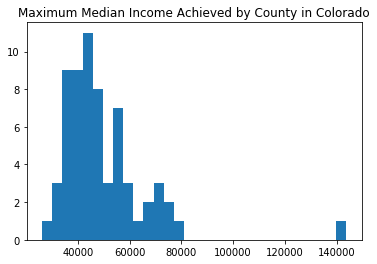

In [24]:
maxPC = income.groupby(by = 'County').agg(max)
plt.hist(maxPC['MedIncome'], bins=30)
plt.title('Maximum Median Income Achieved by County in Colorado')
plt.show()

### Some counties are growing, some aren't ###
Since we have median income and population data for all years in this dataframe, will be interesting to look at how those numbers have shifted for different counties. Next we want to aggregate the data with a calculation for how much the population in each county has increased over a given time period. Here, we will say from 1995 to 2010:

In [25]:
# Years can be modified here if needed in future. Year 1 is beginning year and year 2 is ending year
year1 = 1995
year2 = 2010

# Create a couple dataframes subsetted for the two years declared above, called df1 and df2

df1 = income.loc[income['Year'] == year1].reset_index()
df2 = income.loc[income['Year'] == year2].reset_index()


In [26]:
# Create another new dataframe, called dif, to store the change in population from year1 to year2

dif = pd.DataFrame()

dif['County'] = df1['County']

dif['PopChange'] = (df2['Population'].subtract(df1['Population'])) / df2['Population']
dif.head()

,County,PopChange
0,Adams,0.293547
1,Alamosa,0.097576
2,Arapahoe,0.222551
3,Archuleta,0.411248
4,Baca,-0.188918


The histogram below shows how the population of each county has changed from year 1 to year 2, normalized by the population in year 2 (2010). 

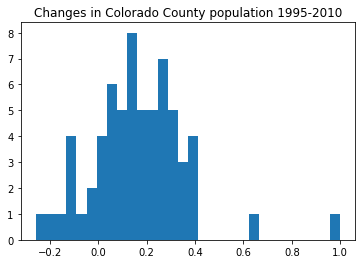

In [27]:
plt.hist(dif['PopChange'], bins=30)
plt.title('Changes in Colorado County population 1995-2010')
plt.show()

In [28]:
# Since we went to the trouble to create the population change values, 
# Add this to the original income dataframe prior to incorporating it into the main dataset

income = pd.merge(income, dif, how = 'left', on = 'County')

In [29]:
income.head()

,County,Year,MedIncome,Population,PopChange
0,Adams,1990,16192,266629.0,0.293547
1,Adams,1991,16647,274311.0,0.293547
2,Adams,1992,17538,284362.0,0.293547
3,Adams,1993,18393,293995.0,0.293547
4,Adams,1994,19262,302197.0,0.293547


Now we want to merge the new income dataframe into the loans dataframe based on both year and county:

In [30]:
df = pd.merge(df, income, how = 'left', left_on=['County_Name','ApprovalFY'], right_on=['County','Year'])

In [31]:
df.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,State_Id,County_Fips,County_Name,TotalLoansInCounty,PIF_RateByCounty,County,Year,MedIncome,Population,PopChange
19367,8771344008,DAHL-HOUSE CONSTRUCTION,Indian Hills,CO,80454,U.S. BANK NATIONAL ASSOCIATION,OH,238110,7-Apr-05,2005,...,CO,08059,Jefferson,1556,0.821979,Jefferson,2005,41754,519675.0,0.081159
19368,8955463007,CRYSTAL STIX,Moffat,CO,81143,VECTRA BK COLORADO NATL ASSOC,NM,339920,24-Jan-96,1996,...,CO,08109,Saguache,12,1,Saguache,1996,15121,5413.0,0.152379
19369,9253773006,ROMEO LIQUORS,Romeo,CO,81148,VECTRA BK COLORADO NATL ASSOC,NM,445310,6-May-96,1996,...,CO,08021,Conejos,8,1,Conejos,1996,13819,7995.0,0.048722
19370,9497963000,SKC ACCOUNTING SERVICES,Holly,CO,81047,VALLEY NATL BANK A BRANCH OF,CO,0,29-Aug-96,1996,...,CO,08099,Prowers,15,0.8,Prowers,1996,18021,14046.0,-0.110333
19371,9597073001,"TINY'S COUNTRY STORE, INC.",Granada,CO,81041,SCEDD DEVELOPMENT COMPANY,CO,0,30-Sep-96,1996,...,CO,08099,Prowers,15,0.8,Prowers,1996,18021,14046.0,-0.110333


## Adding Data: Employment and Unemployment by County, from GoCode Colorado ##
Next, we add labor department data for employment and unemployment as a function of county and year:

In [32]:
file_unemp = 'Unemployment_Estimates_in_Colorado.csv'

employ = pd.read_csv(file_unemp, usecols=['areaname', 'periodyear', 'pertypdesc','laborforce', 'emplab','unemp','unemprate' ])
#employ = pd.read_csv(file_unemp)

# Wrangle and tidy dataset for use:

employ = employ[employ['areaname'].str.endswith('County')]    # <------ Discard all non-county rows
employ = employ[employ['periodyear'] >= 1990]                 # <------ Discard all dates prior to 1990
employ = employ[employ['pertypdesc'] == 'Annual']             # <------ Discard all monthly data

employ.head()

,areaname,periodyear,pertypdesc,laborforce,emplab,unemp,unemprate
711,Adams County,1990,Annual,140544,132385,8159,5.8
724,Adams County,1991,Annual,142002,134516,7486,5.3
737,Adams County,1992,Annual,145671,137195,8476,5.8
750,Adams County,1993,Annual,150890,142831,8059,5.3
763,Adams County,1994,Annual,158763,151849,6914,4.4


In [33]:
# Drop unneeded columns and rename others to match title case and create more meaningful column names

employ['areaname'] = employ['areaname'].str.replace(' County', '')
employ = employ.drop(columns = ['pertypdesc'])
employ.columns = ['County', 'Year', 'LaborForceInCty', 'EmployedInCty','UnempInCty','UnempRateInCty']
employ.reset_index()

,index,County,Year,LaborForceInCty,EmployedInCty,UnempInCty,UnempRateInCty
0,711,Adams,1990,140544,132385,8159,5.8
1,724,Adams,1991,142002,134516,7486,5.3
2,737,Adams,1992,145671,137195,8476,5.8
3,750,Adams,1993,150890,142831,8059,5.3
4,763,Adams,1994,158763,151849,6914,4.4
...,...,...,...,...,...,...,...
1915,32806,Elbert,2018,15034,14628,406,2.7
1916,32841,Lake,2016,4613,4481,132,2.9
1917,32877,Kit Carson,2016,4534,4438,96,2.1
1918,32902,Baca,2019,2175,2138,37,1.7


In [34]:
df = pd.merge(df, employ, how = 'left', left_on=['County_Name','ApprovalFY'], right_on=['County','Year'])

In [35]:
df.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,Year_x,MedIncome,Population,PopChange,County_y,Year_y,LaborForceInCty,EmployedInCty,UnempInCty,UnempRateInCty
19367,8771344008,DAHL-HOUSE CONSTRUCTION,Indian Hills,CO,80454,U.S. BANK NATIONAL ASSOCIATION,OH,238110,7-Apr-05,2005,...,2005,41754,519675.0,0.081159,Jefferson,2005,304514,289606,14908,4.9
19368,8955463007,CRYSTAL STIX,Moffat,CO,81143,VECTRA BK COLORADO NATL ASSOC,NM,339920,24-Jan-96,1996,...,1996,15121,5413.0,0.152379,Saguache,1996,2783,2463,320,11.5
19369,9253773006,ROMEO LIQUORS,Romeo,CO,81148,VECTRA BK COLORADO NATL ASSOC,NM,445310,6-May-96,1996,...,1996,13819,7995.0,0.048722,Conejos,1996,3699,3375,324,8.8
19370,9497963000,SKC ACCOUNTING SERVICES,Holly,CO,81047,VALLEY NATL BANK A BRANCH OF,CO,0,29-Aug-96,1996,...,1996,18021,14046.0,-0.110333,Prowers,1996,6615,6335,280,4.2
19371,9597073001,"TINY'S COUNTRY STORE, INC.",Granada,CO,81041,SCEDD DEVELOPMENT COMPANY,CO,0,30-Sep-96,1996,...,1996,18021,14046.0,-0.110333,Prowers,1996,6615,6335,280,4.2


## Adding Data: CDC All-Cause Mortality ##
Start working with CDC Mortality Data from CDC WONDER database:

In [36]:
# Read output from WONDER database query: Death rates by county for the year 2000

file = 'Compressed_Mortality.txt'

with open(file, 'r') as dat:
    lines = dat.readlines()
    
dat.close()

In [37]:
# Convert the read lines into a list of lists

mortal_list = []

for line in lines:
    linelist = line.strip('\n').split('\t')
    linelist[1] = linelist[1][1:-12]
    linelist[2] = linelist[2][1:-1]
    mortal_list.append(linelist)

In [38]:
# Convert the list object into a dataframe, with header information

mortal = pd.DataFrame(mortal_list)

new_header = mortal.iloc[0]                    # <-------------grab the first row for the header
mortal = mortal[1:]                            # <-------------take the data less the header row
mortal.columns = new_header                    # <-------------set the header row as the df header

In [39]:
mortal.head()

,,,County Code,Deaths,Population,Crude Rate,% of Total Deaths
1,,Baca,08009,62,4517,1372.6,0.2%
2,,Phillips,08095,58,4480,1294.6,0.2%
3,,Las Animas,08071,181,15207,1190.2,0.7%
4,,Otero,08089,235,20311,1157.0,0.9%
5,,Costilla,08023,42,3663,1146.6,0.2%


In [40]:
# For now, just keep the deaths per 100,000 people statistic for each county:

mortal = mortal.drop(columns = ['Deaths', 'Population', '% of Total Deaths'])
mortal.head()

,,,County Code,Crude Rate
1,,Baca,08009,1372.6
2,,Phillips,08095,1294.6
3,,Las Animas,08071,1190.2
4,,Otero,08089,1157.0
5,,Costilla,08023,1146.6


In [41]:
# There is still a "dummy" column in the DataFrame, an artifact of the way we split the strings
mortal.columns

Index(['', '', 'County Code', 'Crude Rate'], dtype='object', name=0)

In [42]:
# Rename columns to appropriate title formats
# Eliminate "Dummy" column so it doesn't get merged

mortal.columns = ['Dummy','County', 'County_Fips', 'DeathsPer100k']
mortal = mortal.drop(columns = ['Dummy', 'County_Fips'])
mortal.head()

,County,DeathsPer100k
1,Baca,1372.6
2,Phillips,1294.6
3,Las Animas,1190.2
4,Otero,1157.0
5,Costilla,1146.6


In [43]:
df = pd.merge(df, mortal, how = 'left', left_on=['County_Name'], right_on=['County'])

In [44]:
df.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,Population,PopChange,County_y,Year_y,LaborForceInCty,EmployedInCty,UnempInCty,UnempRateInCty,County,DeathsPer100k
19367,8771344008,DAHL-HOUSE CONSTRUCTION,Indian Hills,CO,80454,U.S. BANK NATIONAL ASSOCIATION,OH,238110,7-Apr-05,2005,...,519675.0,0.081159,Jefferson,2005,304514,289606,14908,4.9,Jefferson,593.3
19368,8955463007,CRYSTAL STIX,Moffat,CO,81143,VECTRA BK COLORADO NATL ASSOC,NM,339920,24-Jan-96,1996,...,5413.0,0.152379,Saguache,1996,2783,2463,320,11.5,Saguache,794.3
19369,9253773006,ROMEO LIQUORS,Romeo,CO,81148,VECTRA BK COLORADO NATL ASSOC,NM,445310,6-May-96,1996,...,7995.0,0.048722,Conejos,1996,3699,3375,324,8.8,Conejos,1071.4
19370,9497963000,SKC ACCOUNTING SERVICES,Holly,CO,81047,VALLEY NATL BANK A BRANCH OF,CO,0,29-Aug-96,1996,...,14046.0,-0.110333,Prowers,1996,6615,6335,280,4.2,Prowers,876.9
19371,9597073001,"TINY'S COUNTRY STORE, INC.",Granada,CO,81041,SCEDD DEVELOPMENT COMPANY,CO,0,30-Sep-96,1996,...,14046.0,-0.110333,Prowers,1996,6615,6335,280,4.2,Prowers,876.9


## ...And Finally, Some Housecleaning of the Main Dataset ##
Here we'll remove columns we don't need, and make sure that columns that remain are in data types that are useful.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19372 entries, 0 to 19371
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LoanNr_ChkDgt       19372 non-null  int64  
 1   Name                19372 non-null  object 
 2   City                19372 non-null  object 
 3   State               19372 non-null  object 
 4   Zip                 19372 non-null  int64  
 5   Bank                19352 non-null  object 
 6   BankState           19352 non-null  object 
 7   NAICS               19372 non-null  int64  
 8   ApprovalDate        19372 non-null  object 
 9   ApprovalFY          19372 non-null  int64  
 10  Term                19372 non-null  int64  
 11  NoEmp               19372 non-null  int64  
 12  NewExist            19370 non-null  float64
 13  CreateJob           19372 non-null  int64  
 14  RetainedJob         19372 non-null  int64  
 15  FranchiseCode       19372 non-null  int64  
 16  Urba

In [46]:
# First step is to remove redundant or single-value columns from merges
df = df.drop(columns = ['County', 'Year_y', 'County_x', 'Year_x', 'County_y', 'State_Id', 'State'])

# Also drop columns that don't code useful info, like zip codes and loan numbers
df = df.drop(columns = ['LoanNr_ChkDgt', 'Zip'])

In [47]:
df.head().T

,0,1,2,3,4
Name,MICHAEL GADEKEN DDS PC,"MINE TECHNOLOGIES,INC.","CRAIG M. DROSKIN, D.D.S.",Johnny R. Webb II DBA Webb's A,THE DONUT SHOP PLUS
City,Grand Junction,Grand Junction,Grand Junction,Grand Junction,Grand Junction
Bank,WELLS FARGO BANK NATL ASSOC,ANB BANK,WELLS FARGO BANK NATL ASSOC,CAPITAL ONE NATL ASSOC,ANB BANK
BankState,SD,CO,SD,VA,CO
NAICS,621210,333131,621210,811111,0
ApprovalDate,7-Feb-06,7-Mar-97,14-Mar-97,25-Oct-04,16-Apr-97
ApprovalFY,2006,1997,1997,2005,1997
Term,264,60,120,35,60
NoEmp,9,2,4,3,2
NewExist,1,1,1,1,1


We will do more data cleaning later, but for now the dataset is looking pretty decent, with unique columns, each with potentially useful information. 

## EDA: How does PIF rate vary with loan size? ##
The following section deals with getting the loan repayment rate as a function of the size of the loan, across the entire Colorado dataset. We'll do this using the "DisbursementGross" column from the SBA loan dataset. 

In [48]:
# Convert DisbursementGross column to numeric

df['DisbursementGross'] = df['DisbursementGross'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float)


We can see in the histogram plot below that loan size distribution appears to be somewhat exponential or Poisson in shape, with the majority of loans being small loans.  

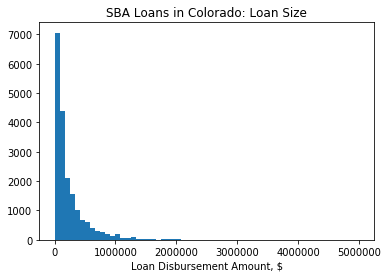

In [49]:
plt.hist(df['DisbursementGross'], bins = 60)
plt.xlabel('Loan Disbursement Amount, $')
plt.title('SBA Loans in Colorado: Loan Size')
plt.show()

In [50]:
# We start by creating a list representing the bin limits for the loan size data.
# For starters we will bins loans in increments of $50,000.

binz = list(range(0,20))
binz = [50000 * x for x in binz]
print(binz)
   

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000]


In [51]:
# Create a dictionary object that, for each element in binz, stores an associated PIF rate:
bin_qty = dict()

for i in binz[0:-1]:
    sub_df = df[(df['DisbursementGross'] > i) & (df['DisbursementGross'] <= (i+50000))]
    good_loans = sub_df['MIS_Status'].value_counts('P I F')[0]
    bin_qty[i] = good_loans

In [52]:
print(bin_qty)

{0: 0.7541053529537215, 50000: 0.7830620549338759, 100000: 0.8087748344370861, 150000: 0.8676569885212694, 200000: 0.8669950738916257, 250000: 0.8827361563517915, 300000: 0.8898186889818689, 350000: 0.8867924528301887, 400000: 0.9244851258581236, 450000: 0.9190283400809717, 500000: 0.9096774193548387, 550000: 0.9233449477351916, 600000: 0.9, 650000: 0.9237668161434978, 700000: 0.917098445595855, 750000: 0.8794326241134752, 800000: 0.8363636363636363, 850000: 0.8818181818181818, 900000: 0.9555555555555556}


In [53]:
# Subsequently convert the dictionary object into a DataFrame

PIF_by_size = pd.DataFrame(bin_qty.items(), columns=['Loan', 'PIF_Rate'])

We can see in the plot below that small loans seem to get paid back less than larger ones, no doubt this will be a useful insight in our model creation. 

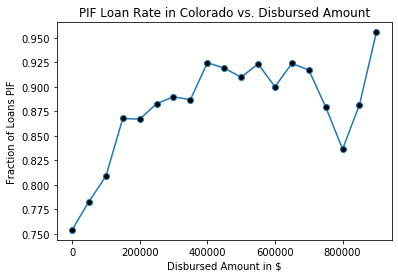

In [54]:
plt.plot(PIF_by_size['Loan'], PIF_by_size['PIF_Rate'], linestyle='-', marker='o', markerfacecolor='black')
plt.xlabel('Disbursed Amount in $')
plt.ylabel('Fraction of Loans PIF')
plt.title('PIF Loan Rate in Colorado vs. Disbursed Amount')
plt.show()

In [55]:
# To Be Continued...

In [56]:
# Write the resulting DataFrame to csv for storage for later use. 

file_name = 'SBA_Model_Input.csv'
df.to_csv(file_name, encoding='utf-8', index=False)